# Dataset

In [1]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 3s 0us/step


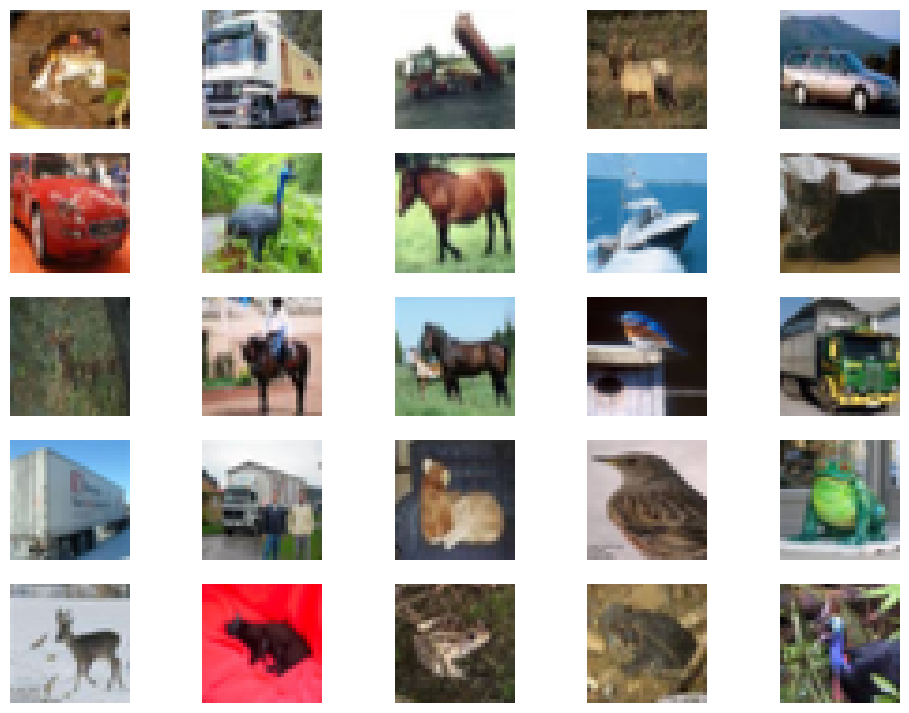

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()     # Training Data 50 000 images ..... Testing Data 10 000 images.

plt.figure(figsize=(12, 9))
for i in range(25):
    plt.subplot(5, 5, 1+i)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
X_test.shape

(10000, 32, 32, 3)

# Models Building

## Descriminator

In [5]:
from keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, BatchNormalization, LeakyReLU, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [6]:
img_shape = (32, 32, 3)
n_classes = 10
embed_size = 64

# Encode the label to concatenate it with the images
inp_labels = Input(shape=(1,)) # labels from 0 to 9
embed = Embedding(n_classes, embed_size)(inp_labels) # (10_classes,  64_Embedding_Size)

fc = Dense(img_shape[0]*img_shape[1])(embed) # Fully Connected Layer with 1024 neurons
reshaped_labels = Reshape((img_shape[0], img_shape[1], 1))(fc) # Reshape the output from the fc layer to (32, 32, 1)

# Concatenate the reshaped label to the image
inp_images = Input(shape=(img_shape))
concat = Concatenate()([inp_images, reshaped_labels]) # the output shape is (32, 32, 4)

# CNN Architecture like the DCGAN
conv1 = Conv2D(64, 5, 2, 'same')(concat) # parameters names --->>>> filters, kernel_size, strides, padding
# conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU()(conv1)
conv1 = Dropout(0.3)(conv1)

conv2 = Conv2D(128, 5, 2, 'same')(conv1)
# conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU()(conv2)

out = Flatten()(conv2)
out = Dense(1, activation='sigmoid')(out)

# Model Input and Output
discriminator = Model([inp_images, inp_labels], out)

In [7]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 64)                640       ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 1024)              66560     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                              

In [8]:
# Define the optimizer and compile the model
disc_opt = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_opt, metrics=['accuracy'])

## Generator

In [9]:
from keras.layers import Convolution2DTranspose

In [10]:
latent_dim = 128

# The same as Discriminator
inp_labels = Input(shape=(1,)) # labels from 0 to 9
embed = Embedding(n_classes, embed_size)(inp_labels) # (10_classes,  64_Embedding_Size)

fc = Dense(8*8)(embed)
reshaped_labels = Reshape((8, 8, 1))(fc)

inp_latents = Input((latent_dim,))

fc = Dense(8*8*128)(inp_latents) # 8*8*128 is the output shape from the last CNN of the discriminator befor the flatten layer (8*8*128=8192)
fc = LeakyReLU()(fc)
reshaped_fc = Reshape((8, 8, 128))(fc)

concat_inp = Concatenate()([reshaped_fc, reshaped_labels]) # the result shape is (8, 8, 129)

# The same CNNs as discriminator but transposed (Deconvolution)
deconv1 = Convolution2DTranspose(128, 4, 2, 'same')(concat_inp) # parameters names --->>>> filters, kernel_size, strides, padding
# deconv1 = BatchNormalization()(deconv1)
deconv1 = LeakyReLU()(deconv1)
# output size = (16, 16, 128)

deconv2 = Convolution2DTranspose(128, 4, 2, 'same')(deconv1)
# deconv2 = BatchNormalization()(deconv2)
deconv2 = LeakyReLU()(deconv2)
# output size = (32, 32, 128)

out = Conv2D(3, 8, padding='same', activation='tanh')(deconv2)
# output size = (32, 32, 3)

generator = Model([inp_latents, inp_labels], out)

In [11]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 1056768   ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 64)                640       ['input_3[0][0]']             
                                                                                            

## CGAN

In [12]:
discriminator.trainable = False

gen_inp, gen_label = generator.input
gen_out = generator.output
disc_out = discriminator([gen_out, gen_label])

cgan = Model([gen_inp, gen_label], disc_out)

cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 1056768   ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 64)                640       ['input_3[0][0]']             
                                                                                            

In [13]:
cgan_opt = Adam(learning_rate=0.0002, beta_1=0.5)
cgan.compile(loss='binary_crossentropy', optimizer=cgan_opt, metrics=['accuracy'])

# Data Preparation

## Scaling and data type conversion

In [14]:
X_train = X_train.astype('float32')
X_train = (X_train-127.5)/127.5

## Batches and Labels (input for `gan` model)

In [15]:
import numpy as np

In [16]:
def gen_real_imgs(X, y, batch_size):
    batch_idxs = np.random.randint(0, X.shape[0], batch_size)
    Xtrain_batch, labels = X[batch_idxs], y[batch_idxs]

    ytrain_batch = np.ones((batch_size, 1))

    return Xtrain_batch, ytrain_batch, labels

In [17]:
def gen_latent_vecs(latent_size, n_samples, n_classes=10):
    z = np.random.randn(latent_size*n_samples).reshape((n_samples, latent_size))
    y = np.ones((n_samples, 1))
    labels = np.random.randint(0, n_classes, n_samples)
    return z, y, labels

In [18]:
def gen_fake_imgs(generator, latent_size, batch_size):
    latent_vecs, _, labels = gen_latent_vecs(latent_size, batch_size)
    fake_imgs = generator([latent_vecs, labels])
    fake_y = np.zeros((batch_size, 1))
    return fake_imgs, fake_y, labels

# Training

In [19]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [20]:
epochs = 41
mini_batch_size = 128
n_batches_per_epoch = int(X_train.shape[0]/mini_batch_size) # int(50000 training images / 128 mini_batch_size) = 390 mini batches (or iterations) per epoch

In [22]:
# minAvgLoss = np.inf
real_loss_per_epoch, fake_loss_per_epoch, cgan_loss_per_epoch = [], [], []
real_acc_per_epoch, fake_acc_per_epoch, cgan_acc_per_epoch = [], [], []

for epoch in range(epochs):
    real_losses, fake_losses, cgan_losses = [], [], []
    real_accs, fake_accs, cgan_accs = [], [], []
    for mini_batch_size in tqdm(range(n_batches_per_epoch)):
        # Train discriminator on the real data images
        X_real, y_real, labels_real = gen_real_imgs(X_train, y_train, int(mini_batch_size/2))
        disc_loss_real, disc_acc_real = discriminator.train_on_batch([X_real, labels_real], y_real)
        real_losses.append(disc_loss_real)
        real_accs.append(disc_acc_real)

        # Train discriminator on the generated fake images
        X_fake, y_fake, labels_fake = gen_fake_imgs(generator, latent_size=128, batch_size=int(mini_batch_size/2))
        disc_loss_fake, disc_acc_fake = discriminator.train_on_batch([X_fake, labels_fake], y_fake)
        fake_losses.append(disc_loss_fake)
        fake_accs.append(disc_acc_fake)

        # Train the generator to optimize its fake images
        X_latent, y_latent, labels_latent = gen_latent_vecs(latent_size=128, n_samples=mini_batch_size)
        cgan_loss, cgan_acc = cgan.train_on_batch([X_latent, labels_latent], y_latent)
        cgan_losses.append(cgan_loss)
        cgan_accs.append(cgan_acc)

    AvgRealLoss, AvgFakeLoss, AvgCGanLoss = sum(real_losses)/len(real_losses), sum(fake_losses)/len(fake_losses), sum(cgan_losses)/len(cgan_losses)
    AvgRealAcc, AvgFakeAcc, AvgCGanAcc = sum(real_accs)/len(real_accs), sum(fake_accs)/len(fake_accs), sum(cgan_accs)/len(cgan_accs)
    print(f"Epoch: {epoch+1}\navg_CGan_loss = {round(AvgCGanLoss, 4)}      -----------------------      avg_CGan_acc = {round(AvgCGanAcc, 4)}\n\n")
    real_loss_per_epoch.append(AvgRealLoss); real_acc_per_epoch.append(AvgRealAcc)
    fake_loss_per_epoch.append(AvgFakeLoss); fake_acc_per_epoch.append(AvgFakeAcc)
    cgan_loss_per_epoch.append(AvgCGanLoss); cgan_acc_per_epoch.append(AvgCGanAcc)
    # if cgan_loss < minAvgLoss:
    #     minAvgLoss = cgan_loss
    #     generator.save('cifar_conditional_generator.h5')

100%|██████████| 390/390 [22:54<00:00,  3.52s/it]


Epoch: 1
avg_CGan_loss = 1.2736      -----------------------      avg_CGan_acc = 0.1327




100%|██████████| 390/390 [01:00<00:00,  6.48it/s]


Epoch: 2
avg_CGan_loss = 0.9493      -----------------------      avg_CGan_acc = 0.1958




100%|██████████| 390/390 [01:00<00:00,  6.44it/s]


Epoch: 3
avg_CGan_loss = 0.8776      -----------------------      avg_CGan_acc = 0.1833




100%|██████████| 390/390 [00:59<00:00,  6.51it/s]


Epoch: 4
avg_CGan_loss = 0.854      -----------------------      avg_CGan_acc = 0.2332




100%|██████████| 390/390 [01:00<00:00,  6.49it/s]


Epoch: 5
avg_CGan_loss = 0.8111      -----------------------      avg_CGan_acc = 0.3026




100%|██████████| 390/390 [01:00<00:00,  6.44it/s]


Epoch: 6
avg_CGan_loss = 0.7841      -----------------------      avg_CGan_acc = 0.3203




100%|██████████| 390/390 [01:00<00:00,  6.44it/s]


Epoch: 7
avg_CGan_loss = 0.7852      -----------------------      avg_CGan_acc = 0.3214




100%|██████████| 390/390 [00:59<00:00,  6.51it/s]


Epoch: 8
avg_CGan_loss = 0.8072      -----------------------      avg_CGan_acc = 0.3268




100%|██████████| 390/390 [01:00<00:00,  6.50it/s]


Epoch: 9
avg_CGan_loss = 0.8069      -----------------------      avg_CGan_acc = 0.3179




100%|██████████| 390/390 [01:00<00:00,  6.44it/s]


Epoch: 10
avg_CGan_loss = 0.7912      -----------------------      avg_CGan_acc = 0.3125




100%|██████████| 390/390 [01:00<00:00,  6.47it/s]


Epoch: 11
avg_CGan_loss = 0.7987      -----------------------      avg_CGan_acc = 0.3109




100%|██████████| 390/390 [00:59<00:00,  6.55it/s]


Epoch: 12
avg_CGan_loss = 0.7969      -----------------------      avg_CGan_acc = 0.3126




100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


Epoch: 13
avg_CGan_loss = 0.7846      -----------------------      avg_CGan_acc = 0.3267




100%|██████████| 390/390 [00:59<00:00,  6.54it/s]


Epoch: 14
avg_CGan_loss = 0.7754      -----------------------      avg_CGan_acc = 0.3173




100%|██████████| 390/390 [00:59<00:00,  6.51it/s]


Epoch: 15
avg_CGan_loss = 0.7689      -----------------------      avg_CGan_acc = 0.3214




100%|██████████| 390/390 [01:00<00:00,  6.42it/s]


Epoch: 16
avg_CGan_loss = 0.7792      -----------------------      avg_CGan_acc = 0.3072




100%|██████████| 390/390 [00:59<00:00,  6.52it/s]


Epoch: 17
avg_CGan_loss = 0.775      -----------------------      avg_CGan_acc = 0.3039




100%|██████████| 390/390 [01:01<00:00,  6.36it/s]


Epoch: 18
avg_CGan_loss = 0.7809      -----------------------      avg_CGan_acc = 0.2942




100%|██████████| 390/390 [01:00<00:00,  6.48it/s]


Epoch: 19
avg_CGan_loss = 0.7838      -----------------------      avg_CGan_acc = 0.3065




100%|██████████| 390/390 [00:59<00:00,  6.58it/s]


Epoch: 20
avg_CGan_loss = 0.7901      -----------------------      avg_CGan_acc = 0.3057




100%|██████████| 390/390 [00:59<00:00,  6.60it/s]


Epoch: 21
avg_CGan_loss = 0.7752      -----------------------      avg_CGan_acc = 0.3196




100%|██████████| 390/390 [01:00<00:00,  6.42it/s]


Epoch: 22
avg_CGan_loss = 0.7752      -----------------------      avg_CGan_acc = 0.3118




100%|██████████| 390/390 [01:00<00:00,  6.45it/s]


Epoch: 23
avg_CGan_loss = 0.7799      -----------------------      avg_CGan_acc = 0.3111




100%|██████████| 390/390 [01:00<00:00,  6.47it/s]


Epoch: 24
avg_CGan_loss = 0.7626      -----------------------      avg_CGan_acc = 0.3335




100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


Epoch: 25
avg_CGan_loss = 0.7659      -----------------------      avg_CGan_acc = 0.3317




100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


Epoch: 26
avg_CGan_loss = 0.7699      -----------------------      avg_CGan_acc = 0.3259




100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


Epoch: 27
avg_CGan_loss = 0.7854      -----------------------      avg_CGan_acc = 0.3178




100%|██████████| 390/390 [01:02<00:00,  6.20it/s]


Epoch: 28
avg_CGan_loss = 0.7528      -----------------------      avg_CGan_acc = 0.3351




100%|██████████| 390/390 [01:03<00:00,  6.17it/s]


Epoch: 29
avg_CGan_loss = 0.7521      -----------------------      avg_CGan_acc = 0.3354




100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


Epoch: 30
avg_CGan_loss = 0.7518      -----------------------      avg_CGan_acc = 0.3385




100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


Epoch: 31
avg_CGan_loss = 0.7479      -----------------------      avg_CGan_acc = 0.3401




100%|██████████| 390/390 [01:07<00:00,  5.74it/s]


Epoch: 32
avg_CGan_loss = 0.7427      -----------------------      avg_CGan_acc = 0.3423




100%|██████████| 390/390 [01:07<00:00,  5.78it/s]


Epoch: 33
avg_CGan_loss = 0.7654      -----------------------      avg_CGan_acc = 0.3192




100%|██████████| 390/390 [01:08<00:00,  5.72it/s]


Epoch: 34
avg_CGan_loss = 0.7509      -----------------------      avg_CGan_acc = 0.3297




100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


Epoch: 35
avg_CGan_loss = 0.7417      -----------------------      avg_CGan_acc = 0.3339




100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


Epoch: 36
avg_CGan_loss = 0.7542      -----------------------      avg_CGan_acc = 0.3137




100%|██████████| 390/390 [01:06<00:00,  5.85it/s]


Epoch: 37
avg_CGan_loss = 0.76      -----------------------      avg_CGan_acc = 0.3215




100%|██████████| 390/390 [01:01<00:00,  6.32it/s]


Epoch: 38
avg_CGan_loss = 0.7514      -----------------------      avg_CGan_acc = 0.3197




100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


Epoch: 39
avg_CGan_loss = 0.7526      -----------------------      avg_CGan_acc = 0.3201




100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


Epoch: 40
avg_CGan_loss = 0.7546      -----------------------      avg_CGan_acc = 0.3281




100%|██████████| 390/390 [01:01<00:00,  6.34it/s]

Epoch: 41
avg_CGan_loss = 0.7473      -----------------------      avg_CGan_acc = 0.3346




# Evaluation and Prediction

## Evaluations

In [23]:
# from keras.models import load_model
import matplotlib.pyplot as plt

In [44]:
# trained_generator = load_model('cifar_conditional_generator.h5')

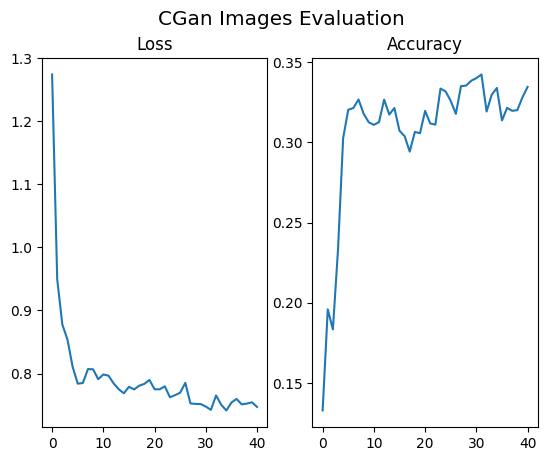

In [34]:
epochs_range = range(epochs)

fig = plt.figure()
fig.suptitle('CGan Images Evaluation', fontsize="x-large")

ax1 = fig.add_subplot(121)
ax1.plot(epochs_range, cgan_loss_per_epoch)
ax1.set_title("Loss")

ax2 = fig.add_subplot(122)
ax2.plot(epochs_range, cgan_acc_per_epoch)
ax2.set_title("Accuracy")

plt.show()
# plt.savefig(f'{titles}.png')

## Predictions

In [27]:
latent_vecs, _, _ = gen_latent_vecs(latent_size=128, n_samples=20)

latent_labels = np.array([l for _ in range(2) for l in range(10)])

predictions = generator.predict([latent_vecs, latent_labels])

1/1 [==============================] - 0s 168ms/step


In [29]:
predictions = (predictions+1)/2.0   # Rescale the imgs from [-1, 1] to [0, 1]
predictions *= 255   # Multibly the imgs by 255 to be visible to us
predictions = predictions.astype('uint8')

In [30]:
predictions.shape

(20, 32, 32, 3)

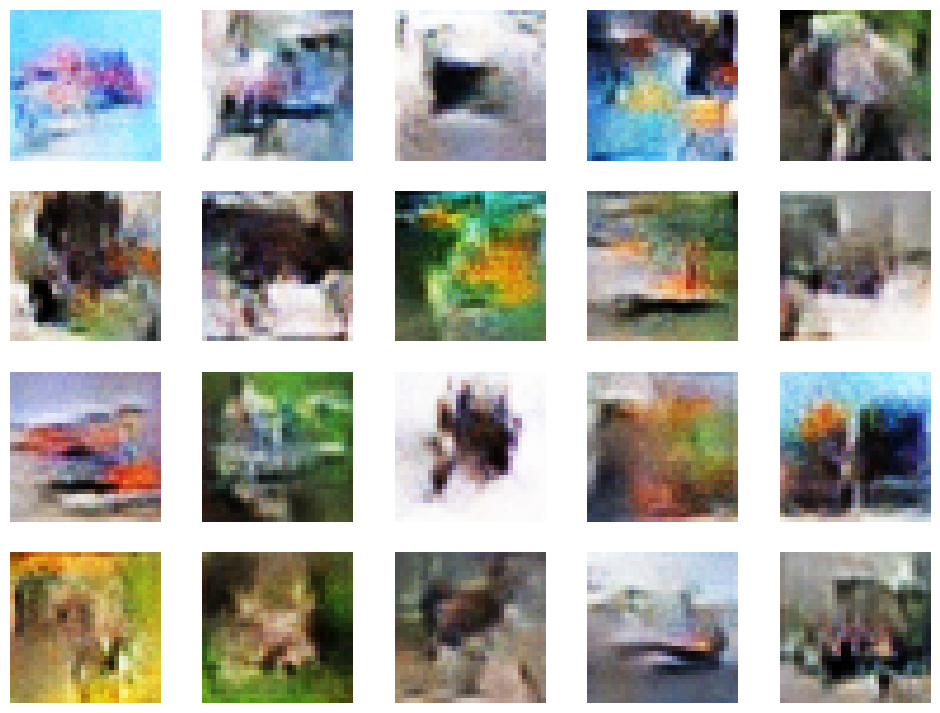

In [32]:
plt.figure(figsize=(12, 9))
for i in range(20):
    plt.subplot(4, 5, 1+i)
    plt.axis('off')
    plt.imshow(predictions[i])
plt.show()